In [13]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

In [14]:
# Load the dataset
(X_train, y_train), (_, _) = cifar10.load_data()

In [15]:
# Normalize the data
X_train = (X_train - 127.5) / 127.5  # Scale images to [-1, 1]

In [16]:
# Create tf.data.Dataset
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size)

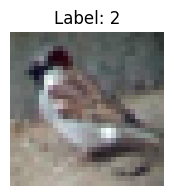

In [17]:
plt.figure(figsize=(2, 2))
idx = np.random.randint(0, len(X_train))
img = image.array_to_img(X_train[idx], scale=True)
plt.imshow(img)
plt.axis('off')
plt.title(f'Label: {y_train[idx][0]}')
plt.show()

In [18]:
# Define Binary Cross-Entropy Loss
bce_loss = tf.keras.losses.BinaryCrossentropy()

In [19]:
# Discriminator Loss
def discriminator_loss(real, fake):
    real_loss = bce_loss(tf.ones_like(real), real)
    fake_loss = bce_loss(tf.zeros_like(fake), fake)
    return real_loss + fake_loss

In [20]:
# Generator Loss
def generator_loss(preds):
    return bce_loss(tf.ones_like(preds), preds)

In [21]:
# Optimizers
d_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

In [37]:
def build_generator():
    in_label = tf.keras.layers.Input(shape=(1,))
    li = tf.keras.layers.Embedding(10, 50)(in_label)  # Assuming 10 classes
    li = tf.keras.layers.Dense(8 * 8)(li)
    li = tf.keras.layers.Reshape((8, 8, 1))(li)

    in_lat = tf.keras.layers.Input(shape=(100,))
    gen = tf.keras.layers.Dense(128 * 8 * 8)(in_lat)
    gen = tf.keras.layers.LeakyReLU(negative_slope=0.2)(gen)
    gen = tf.keras.layers.Reshape((8, 8, 128))(gen)

    merge = tf.keras.layers.Concatenate()([gen, li])
    gen = tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(merge)
    gen = tf.keras.layers.LeakyReLU(negative_slope=0.2)(gen)
    gen = tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(gen)
    out_layer = tf.keras.layers.Conv2D(3, (8, 8), activation='tanh', padding='same')(gen)

    return Model([in_lat, in_label], out_layer)

In [38]:
def build_discriminator():
    in_image = tf.keras.layers.Input(shape=(32, 32, 3))  # CIFAR-10 image size
    in_label = tf.keras.layers.Input(shape=(1,))
    li = tf.keras.layers.Embedding(10, 50)(in_label)
    li = tf.keras.layers.Dense(32 * 32)(li)
    li = tf.keras.layers.Reshape((32, 32, 1))(li)

    merge = tf.keras.layers.Concatenate()([in_image, li])
    x = tf.keras.layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same')(merge)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Flatten()(x)
    out_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    return Model([in_image, in_label], out_layer)

d_model = build_discriminator()
d_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 1, 50)          │            500 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 1, 1024)        │         52,224 │ embedding_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_10            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_8 (Reshape)       │ (None, 32, 32, 1)      │              0 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 32, 32, 4)      │              0 │ input_layer_10[0][0],  │
│ (Concatenate)             │                        │                │ reshape_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 64)     │          4,160 │ concatenate_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_8 (LeakyReLU) │ (None, 16, 16, 64)     │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 128)      │        131,200 │ leaky_re_lu_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_9 (LeakyReLU) │ (None, 8, 8, 128)      │              0 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 8192)           │              0 │ leaky_re_lu_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 1)              │          8,193 │ flatten_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 196,277 (766.71 KB)

 Trainable params: 196,277 (766.71 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
def generate_and_save_images(model, epoch, test_input, labels):
    predictions = model([test_input, labels])
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i] + 1) / 2)  # Scale back to [0, 1]
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

In [41]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for real_images, labels in dataset:
            # Generate noise
            noise = tf.random.normal([batch_size, 100])
            generated_images = g_model([noise, labels])

            # Discriminator training
            with tf.GradientTape() as d_tape:
                real_output = d_model([real_images, labels])
                fake_output = d_model([generated_images, labels])
                d_loss = discriminator_loss(real_output, fake_output)

            gradients_of_discriminator = d_tape.gradient(d_loss, d_model.trainable_variables)
            clipped_d_gradients = [tf.clip_by_norm(g, 1.0) for g in gradients_of_discriminator]
            d_optimizer.apply_gradients(zip(clipped_d_gradients, d_model.trainable_variables))

            # Generator training
            with tf.GradientTape() as g_tape:
                generated_images = g_model([noise, labels])
                fake_output = d_model([generated_images, labels])
                g_loss = generator_loss(fake_output)

            gradients_of_generator = g_tape.gradient(g_loss, g_model.trainable_variables)
            clipped_g_gradients = [tf.clip_by_norm(g, 1.0) for g in gradients_of_generator]
            g_optimizer.apply_gradients(zip(clipped_g_gradients, g_model.trainable_variables))

        # Log progress
        print(f'Epoch {epoch + 1}, Discriminator Loss: {d_loss.numpy():.4f}, Generator Loss: {g_loss.numpy():.4f}')

        # Generate and save images
        test_noise = tf.random.normal([16, 100])
        test_labels = tf.random.uniform([16], minval=0, maxval=10, dtype=tf.int32)
        generate_and_save_images(g_model, epoch + 1, test_noise, test_labels)

In [42]:
# Build the generator model
g_model = build_generator()

In [43]:
# Define the function for generating and displaying images
def generate_images(model, test_input, label):
    predictions = model([test_input, label])
    plt.figure(figsize=(10, 10))
    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i + 1)
        plt.imshow((predictions[i] + 1) / 2)  # Rescale from [-1, 1] to [0, 1]
        plt.axis('off')
    plt.show()

In [44]:
# Generate random noise and specify a label
test_input = tf.random.normal([25, 100])
label = tf.constant([[0]] * 25)  # Example for label '0'

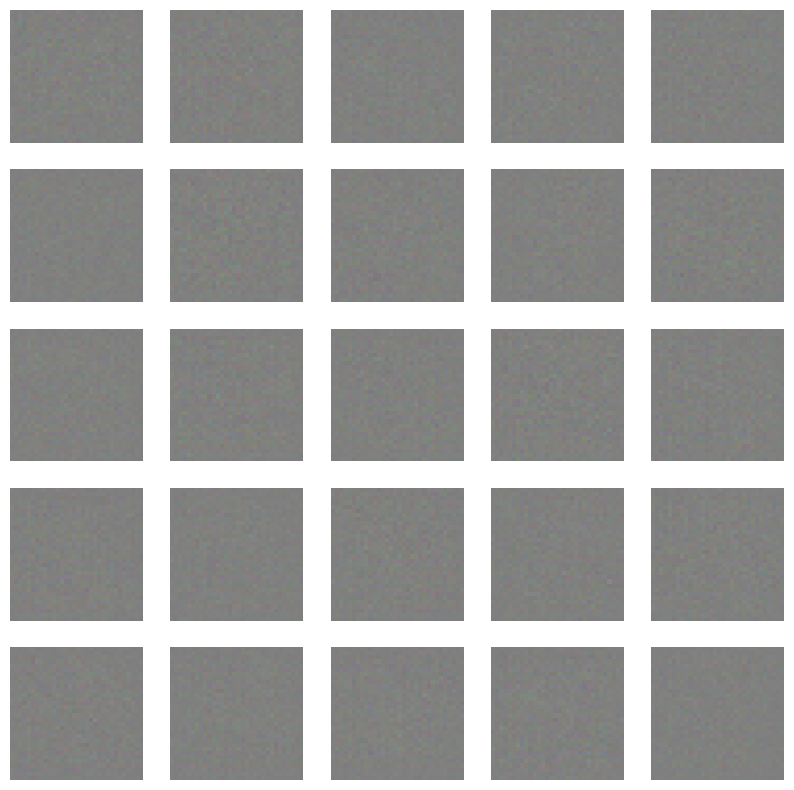

In [45]:
# Generate and display images
generate_images(g_model, test_input, label)